# Caustic Effect

I make these notes available here for allowing for others to understand and suggest improvements. References are provided in the text in the case I was not completely clear. I suggest skipping them if you understand the concept.

The caustic effect is an effect where light rays concentrates in lines due to refraction and reflection, often caused by these rays passing through waves. An accurate effect would require (as explained by [GPUGems Chapter 2](<https://developer.nvidia.com/gpugems/gpugems/part-i-natural-effects/chapter-2-rendering-water-caustics>)) a large amount of compute for backward ray tracing. Furtheremore, accurate waves would take a considerable amount of compute time as explored in [GPUGems Chapter 1](<https://developer.nvidia.com/gpugems/gpugems/part-i-natural-effects/chapter-1-effective-water-simulation-physical-models>). These works were written in 2007, thus they proposed efficiency improvements such as aesthetic waves and per texel (the pixel for the texture) speedups, both instead of phsically correct computations. These approaches ended up with realistic and efficient results, but each author procedes separatedly. I combine their works here as a learning experiment.

The Gerstner Wave Function (Laeuchli, Jesse. 2002. "Simple Gerstner Wave Cg Shader." Online article) provides a means for accurate waves. Here, coordinate (x, y, z) of a vertex is found through $ (P_x, P_y, P_z) $, where $ P_z $ is the height of the wave. Some waves begin at a source and move out in a circle, while ocean waves often move in a direction due to wind. This equation is for wind-drive waves.

The purpose is to derive circular  waves from directional waves, generate the caustic effect from light passing through these waves, and an efficient effect for a small button that occurs by hovering over the button.

1. $ W_i $ is reference to wave $ i $.
2. $ A_i $ is for the amplitude of wave $ i $.
3. $ \omega_i $ refers to the angular frequency of the wave. To calculate $ \omega_i $, we use $ \omega_i = \frac{2\pi}{T} $, where $ T $ is the period.
4. Remember, linear velocity is the equation by $ \frac{\upsilon}{\omega} = r $
5. Direction ($ D_i $) is a vector $ \begin{pmatrix} D_{ix} \\ D_{iy} \end{pmatrix} $. It is the vector in the direction of the wind.

Okay, you're ready, here's the Gerstner Wave Equation:

$ P_x(x, y, t) = x+\Sigma(Q_iA_iD_{ix})(cos(\omega_i(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix})+t\phi_i)) $

- The entire part after the x is for making points with high heights move closer together for a stronger edge to the waves.
- Q_i controls this incline of the wave.

$ P_y(x, y, t) = y+\Sigma(Q_iA_iD_{iy})(cos((\omega_i)(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix}) + t\phi_i)) $

$ P_z(x, y, t) = \Sigma A_i sin(\omega_i(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix}) + t\phi_i) $

In sum,

$$ F(x, y, t) = \begin{pmatrix} P_x \\ P_y \\ P_z \end{pmatrix} = \begin{pmatrix} x+\Sigma(Q_iA_iD_{ix})(cos(\omega_i(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix})+t\phi_i)) \\ y+\Sigma(Q_iA_iD_{iy})(cos((\omega_i)(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix}) + t\phi_i)) \\ \Sigma A_i sin(\omega_i(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix}) + t\phi_i) \end{pmatrix} $$

In [ ]:
%pip install matplotlib
%pip install numpy
%pip install ipywidgets
%pip install ipython

IntProgress(value=0, max=10000)

Finished


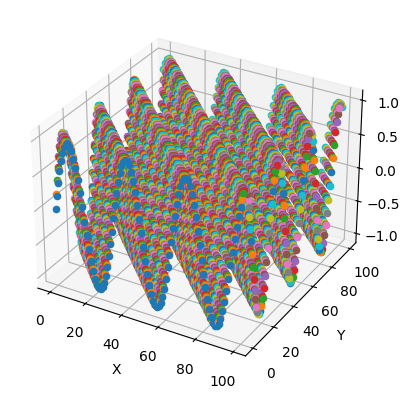

In [3]:
import math
# waves is a list with (Q_i, A_i, w_i, phi_i)
waves = [(0.2, 1, 2*math.pi/1, 1)]
direction = [1, 1]

def f(x, y, t):
  global waves, direction
  x_return = x
  y_return = y
  z_return = 0
  for wave in waves:
    x_return += wave[0] * wave[1] * direction[0] * math.cos(wave[2]*(direction[0] * x + direction[1] * y) + t * wave[3])
    y_return += wave[0] * wave[1] * direction[1] * math.cos(wave[2]*(direction[0] * x + direction[1] * y) + t * wave[3])
    z_return += wave[1]*math.sin(wave[0] * (x + y) + wave[3] * t)
  return [x_return, y_return, z_return]

t_value = 0.0

# https://stackoverflow.com/q/38861829/11705785
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt

# https://stackoverflow.com/a/12414814/11705785
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

max_count = 100*100
progress = IntProgress(min=0, max=max_count)
display(progress)

for x in range(100):
  for y in range(100):
    ax.scatter(*f(x, y, t_value))
    progress.value += 1

print("Finished")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

As we can see in the above diagram, at every crest and trough, there are more vertices than at the equilibrium location of the wave.

To get the normal vector of the wave at a point, we can use the binormal and tangent vector. 

$$ N(x, y) = B(x, y)\times T(x, y) $$

In the previous approach in GPUGems Chapter 1, they calculate  B via $ F_x = \frac{\partial F(x, y, t)}{\partial x} $ and T via $ F_y = \frac{\partial F(x, y, t)}{\partial y} $ to get the normal vector. I find this approach slower than finding the inverses of x and y and using those to find z. This also leads to less calculations, as we will see.

Here's the construction:

$ f(x, y) = u = x+\Sigma(Q_iA_iD_{ix})(cos(\omega_i(D_i\cdot \begin{bmatrix} x \\ y\end{bmatrix})+t\phi_i)) $

With simple rearrangement, We can pull the coefficients out of the wave function:

$ \frac{u-x}{Q_iA_iD_{ix}} = \Sigma cos(\omega_i(D_{ix}x+D_{iy}y)+t\phi_i) $

The taylor series of cosine is (https://tutorial.math.lamar.edu/classes/calcii/taylorseries.aspx):

$$ cos(x) = \Sigma_{n=0}^\infty \frac{f^n(a)}{n!}(x-a)^n = 1-\frac{x^2}{2!}+\frac{x^4}{4!}-\frac{x^6}{6!}+... $$

Assume $ a = 0 $, thus with, say $ x=c(1) $, we have:

$$ cox(x) = cos(c(1)) = \frac{cos(1)cos(c)}{cos(1)} $$

Let's find this ratio

$$ \frac{cos(c)}{cos(1)} = \frac{\Sigma_{n=0}^\infty \frac{f^n(a)}{n!}(a)^n}{\Sigma_{n=0}^\infty \frac{f^n(a)}{n!}(x)^n} = \frac{\Sigma_{n=0}^\infty (c)^n}{\Sigma_{n=0}^\infty(1)^n} $$

Let's try the Chebyshev's Polynomial

cos(a) + cos(b) + cos(c) = T_a cos(1) + T_b cos(1) ... = (T)_a + T_b + T_c) cos(1)




In [43]:
import math
c = 2

# expansion1 = []
# expansiona = []
sumc, sum1 = 0, math.cos(1)
shortsumc = 0

n = 100
for i in range(n):
  # expansion1.append((-1) ** i * (1 ** (2 * i)) / math.factorial(2 * i))
  # expansiona.append((-1) ** i * (c ** (2 * i)) / math.factorial(2 * i))
  sumc += (-1) ** i * (c ** (2 * i)) / math.factorial(2 * i)
  shortsumc += (c ** (2 * i))
shortsumc /= n

# expansiona, expansion1
math.cos(c)/sum1, sum1*shortsumc

(-0.7702111059446461, 2.894107769001238e+57)


One way to to get directional waves is to define the direction as below through the focus (aka center) of the center of the wave F_i:

$$ D_i(x, y) = \frac{(x,y)-F_i}{|(x,y)-F_i|} $$

Here, $ D_i $ is a normalized vector.
